<a href="https://colab.research.google.com/github/neemomo/Codestates_Project1/blob/main/n223-evaluation-metrics-for-classification/n223a-evaluation-metrics-for-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **(Urclass Quiz) 다음 조건에서 F beta score를 구하고 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다.

In [22]:
tp = 4442
tn = 6165
fp = 1515
fn = 1930

precision = tp / (tp + fp)
recall = tp / (tp + fn)

f_beta = 3 * precision * recall / (precision + 2 * recall)
f_beta

0.7287542382150278

### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(Urclass Quiz) 임계값을 증가시킬때 positive 범주의 재현율 변화 중 올바른 설명을 고르세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


In [ ]:
!pip install category-encoders

In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
target = 'vacc_seas_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)

test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv').iloc[:14052]
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

train, val = train_test_split(train, test_size = len(test), 
                              stratify = train[target], random_state = 42)

train.shape, val.shape, test.shape

((28102, 39), (14052, 39), (14052, 38))

In [10]:
features = train.drop(columns = target).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [16]:
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(class_weight = 'balanced')
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 f1:', f1_score(y_pred, y_val))

검증 f1: 0.7262441583996065


### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 하이퍼파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, oob_score=True
- **(Urclass Quiz) 확률값들의 분포의 변화를 아래 보기 중에서 고르세요**
    1. 다양해진다
    2. 변화가없다


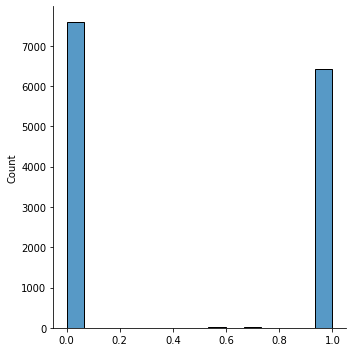

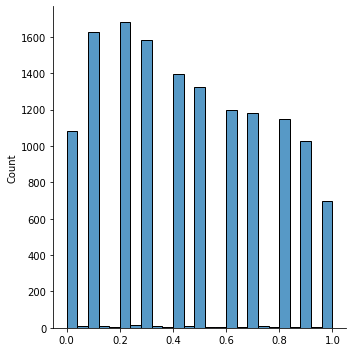

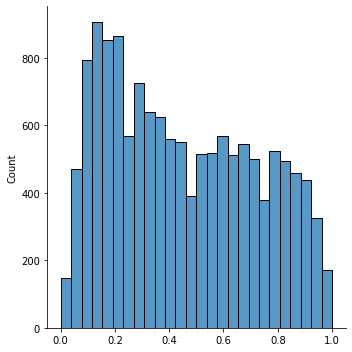

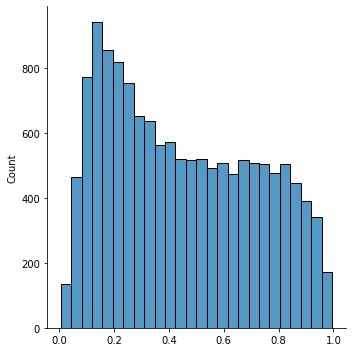

In [21]:
def proba_plot(X_train, y_train, X_val, n_estimators = 100):
    pipe = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(),
        RandomForestClassifier(n_estimators = n_estimators, class_weight = 'balanced')
    )

    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_val)[:, 1]

    sns.displot(y_proba)

for n in [1, 10, 100, 1000]:
    proba_plot(X_train, y_train, X_val, n)

### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **(Urclass Quiz) 캐글 Leaderboard의 본인 Score를 제출하세요.**

In [59]:
pipe1 = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    LogisticRegression(class_weight = 'balanced')
)
pipe2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(class_weight = 'balanced')
)

pipe1.fit(X_train, y_train)
pipe2.fit(X_train, y_train)

y_proba1 = pipe1.predict_proba(X_val)[:, 1]
y_proba2 = pipe2.predict_proba(X_val)[:, 1]

fpr1, tpr1, thresholds1 = roc_curve(y_val, y_proba1)
fpr2, tpr2, thresholds2 = roc_curve(y_val, y_proba2)

roc1 = pd.DataFrame({
    'FPR': fpr1,
    'TPR': tpr1,
    'Threshold': thresholds1
})
roc2 = pd.DataFrame({
    'FPR': fpr2,
    'TPR': tpr2,
    'Thresholds': thresholds2
})

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [60]:
roc1

,FPR,TPR,Threshold
0,0.000000,0.000000,1.992982
1,0.000000,0.000157,0.992982
2,0.000000,0.000471,0.992732
3,0.000130,0.000471,0.992716
4,0.000130,0.002668,0.990332
...,...,...,...
4555,0.994271,0.999686,0.010887
4556,0.994271,0.999843,0.010853
4557,0.995182,0.999843,0.009807
4558,0.995182,1.000000,0.009761


In [61]:
roc2

,FPR,TPR,Thresholds
0,0.000000,0.000000,2.000000
1,0.000000,0.002354,1.000000
2,0.000260,0.008475,0.990000
3,0.001172,0.016008,0.980000
4,0.001172,0.016164,0.977521
...,...,...,...
437,0.991536,0.998588,0.022866
438,0.995573,0.999058,0.020000
439,0.996094,0.999058,0.012533
440,0.999219,0.999686,0.010000


auc: 0.8405571167477506


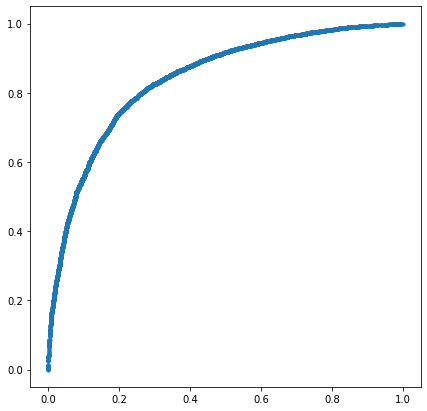

In [62]:
plt.figure(figsize = (7, 7))
plt.scatter(x = 'FPR', y = 'TPR', data = roc1.loc[:, ['FPR', 'TPR']], s = 10);
print('auc:', roc_auc_score(y_val, y_proba1))

auc: 0.8318164225975623


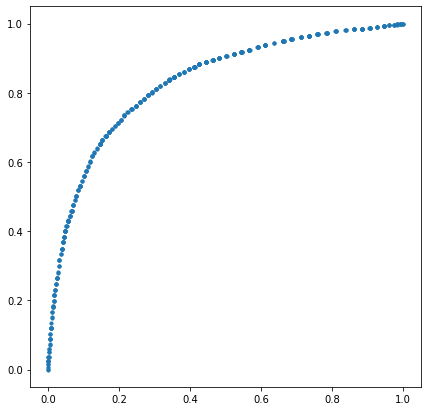

In [63]:
plt.figure(figsize = (7, 7))
plt.scatter(x = 'FPR', y = 'TPR', data = roc2.loc[:, ['FPR', 'TPR']], s = 10);
print('auc:', roc_auc_score(y_val, y_proba2))

## 🔥 도전과제(Github - Discussion)

### 5) confusion matrix, classification report 등을 그려 보시고, 각 평가지표들에 대해 최대한 분석하고 precision과 recall 중 어느 것을 높이는 방향으로 모델링 해야할지 논의해 보세요. 

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 